In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import time
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, DataStructs
from sklearn.decomposition import PCA
from utils import *
from preprocessing import load_data
from RandomFeats import define_rand_feats
from DirectionalVAE import vae_main, generate

In [2]:
### CONFIG
task = 'potency'
K = 32 # Num pca components
percentile = 25 # Upper pth percentile for subsets
solver = False # Solver for LogisticRegression (True - liblin, slower but better)
N = 64 # Num betas to fit (Typically 512 or 1280)
M = 100 # Num betas to generate for inference (Typically 25k-100k)
z = 64 # Latent Dim of VAE
reg = 0.33 # Lambda scale of KL Loss for VAE Training

In [3]:
data = load_data(task, K)

In [4]:
np.random.seed(74)
X, Y = data['train']
D = K * 5
model = define_rand_feats(X, D)

In [5]:
print(X.shape)
print(Y.shape)

(12699, 32)
(12699,)


In [6]:
dirs = np.random.randn(N, K)
dirs = dirs / np.linalg.norm(dirs, axis=1, keepdims=True)

In [7]:
betas = []
accs = []
i = 0
print(f"Starting {len(dirs)} models")
start_time = time.time()
for dir in dirs:
    if i % 25 == 0 and i:
        curr_time = time.time()
        elapsed_time = (curr_time - start_time)/60 # min
        print(f"Step {i} - Time Elapsed: {elapsed_time:.2f} min - est {elapsed_time/i*len(dirs) - elapsed_time:.2f} min remaining")
        print(f"\t\tCurrent Beta Accuracy: {np.mean(np.array(accs))}")

    X_sub, X_ids = project_and_filter(X, dir, percentile)
    Y_sub = Y[X_ids]
    beta, acc = log_coeffs(model(X_sub), Y_sub, solver)

    betas.append(beta)
    accs.append(acc)
    i += 1
    if i == len(dirs) - 1: print(f"Done")

betas = np.array(betas)
accs = np.array(accs)

Starting 64 models
Step 25 - Time Elapsed: 0.33 min - est 0.52 min remaining
		Current Beta Accuracy: 0.8859030197601949
Step 50 - Time Elapsed: 0.66 min - est 0.18 min remaining
		Current Beta Accuracy: 0.887585159408538
Done


In [8]:
betas = tf.squeeze(betas)
dirs = tf.constant(dirs)
print("Modeling Training complete with Subset Accuracies: ", np.mean(accs))

Modeling Training complete with Subset Accuracies:  0.8873049397649054


Accuracy:  0.5846335697399527
Precision:  0.6081730769230769
Recall:  0.6608619939050936


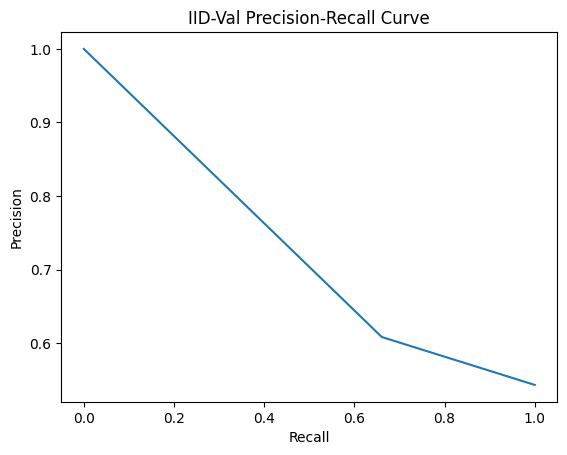

In [9]:
# Eval on iid val data
X_iid_val, Y_iid_val = data['iid_val']
X_iid_val_rand = model(X_iid_val)
evaluate(X_iid_val_rand, Y_iid_val, betas)

In [11]:
# Beta Model
vae_ret = vae_main(dirs, betas, z, X, model(X), percentile, reg)
print(f"VAE Metrics:\n\tTest Loss - {vae_ret['test_loss']}\n\Agreement: Overall - {vae_ret['overall_agreement']}, Subset - {vae_ret['subset_agreement']}")


Epoch 0
Step 0: loss = 267.82904052734375, recon_loss = 265.8739013671875, kl_loss = 5.92464542388916

Epoch 1
Step 0: loss = 240.52317810058594, recon_loss = 236.51397705078125, kl_loss = 12.149080276489258

Epoch 2
Step 0: loss = 226.64328002929688, recon_loss = 221.3372039794922, kl_loss = 16.079004287719727

Epoch 3
Step 0: loss = 202.9112091064453, recon_loss = 194.0138702392578, kl_loss = 26.961612701416016

Epoch 4
Step 0: loss = 200.3489990234375, recon_loss = 192.2270050048828, kl_loss = 24.612083435058594

Epoch 5
Step 0: loss = 188.97488403320312, recon_loss = 183.19142150878906, kl_loss = 17.525659561157227

Epoch 6
Step 0: loss = 187.49880981445312, recon_loss = 182.1158447265625, kl_loss = 16.31203269958496

Epoch 7
Step 0: loss = 184.1665496826172, recon_loss = 179.12060546875, kl_loss = 15.290755271911621

Epoch 8
Step 0: loss = 179.92173767089844, recon_loss = 174.34933471679688, kl_loss = 16.886051177978516

Epoch 9
Step 0: loss = 176.85154724121094, recon_loss = 171

In [12]:
# Draw new betas
gen_dirs, gen_betas = generate(vae_ret['vae'], M, K, z)

Accuracy:  0.4910918227501142
Precision:  0.45172656800563776
Recall:  0.6560900716479018


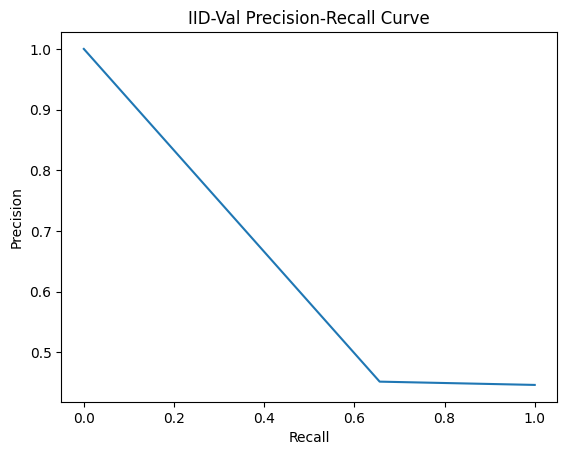

In [13]:
# Eval on ood val data
X_ood_val, Y_ood_val = data['ood_val']
X_ood_val_rand = model(X_ood_val)
evaluate(X_ood_val_rand, Y_ood_val, gen_betas)

Accuracy:  0.5424610051993067
Precision:  0.6163563829787234
Recall:  0.6593172119487909


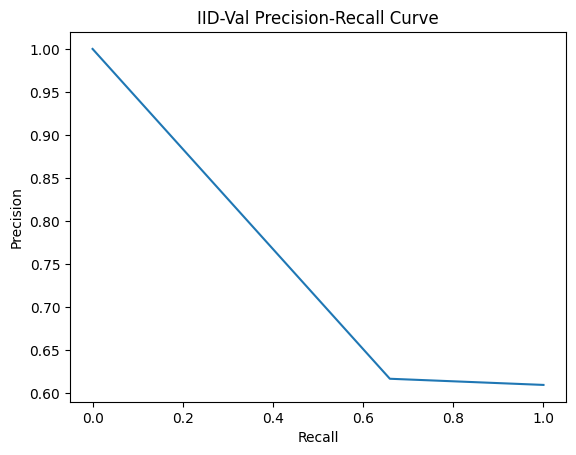

In [14]:
# Eval on ood test data
X_ood_test, Y_ood_test = data['ood_test']
X_ood_test_rand = model(X_ood_test)
evaluate(X_ood_test_rand, Y_ood_test, gen_betas)